# Hierarchical graph modeling using Plasmo.jl

In [1]:
using Plasmo, PlasmoPlots, GLPK

In [2]:
function simple_optigraph(constr_val)
    graph = Plasmo.OptiGraph()

    # create three nodes
    Plasmo.@optinode(graph, n1)
    Plasmo.@variable(n1, y >= 2)
    Plasmo.@variable(n1, x >= 0)
    Plasmo.@constraint(n1, x + y >= constr_val)
    Plasmo.@objective(n1, Min, y)

    Plasmo.@optinode(graph, n2)
    Plasmo.@variable(n2, y >= 2)
    Plasmo.@variable(n2, x >= 0)
    Plasmo.@constraint(n2, x + y >= constr_val)
    Plasmo.@objective(n2, Min, y)

    Plasmo.@optinode(graph, n3)
    Plasmo.@variable(n3, y >= 2)
    Plasmo.@variable(n3, x >= 0)
    Plasmo.@constraint(n3, x + y >= constr_val)
    Plasmo.@objective(n3, Min, y)

    # create a link constraint between nodes (automatically creates an optiedge)
    Plasmo.@linkconstraint(graph, n1[:x] + n2[:x] + n3[:x] == constr_val) # n1[:x] syntax means reading the key which is the variable x of node n1.
    return graph
end

simple_optigraph (generic function with 1 method)

In [3]:
# create multiple graphs
graph1 = simple_optigraph(3)
graph2 = simple_optigraph(5)
graph3 = simple_optigraph(7);

In [4]:
# create high-level graph
graph0 = Plasmo.OptiGraph()
Plasmo.@optinode(graph0, n0)
Plasmo.@variable(n0, x)
Plasmo.@constraint(n0, x >= 0);

In [5]:
# add subgraphs to graph0 (hierarchical graph)
Plasmo.add_subgraph!(graph0, graph1)
Plasmo.add_subgraph!(graph0, graph2)
Plasmo.add_subgraph!(graph0, graph3);

n3 = graph1[3]; n5 = graph2[2]; n7 = graph3[1];

In [6]:
# create linking constraints on graph0 connecting a global node
Plasmo.@linkconstraint(graph0, n0[:x] + n3[:x] == 3)
Plasmo.@linkconstraint(graph0, n0[:x] + n5[:x] == 5)
Plasmo.@linkconstraint(graph0, n0[:x] + n7[:x] == 7)

# add linking constraint to graph0 connecting a global edge
Plasmo.@linkconstraint(graph0, n3[:x]+n5[:x]+n7[:x] == 10);

In [7]:
# optimize with GLPK
JuMP.set_optimizer(graph0, GLPK.Optimizer)
JuMP.optimize!(graph0)

In [8]:
# Query solution
n0 = Plasmo.optinodes(graph0) # high-level graph
n1,n2,n3 = Plasmo.optinodes(graph1) # subgraph1
n4,n5,n6 = Plasmo.optinodes(graph2) # subgraph2
n7,n8,n9 = Plasmo.optinodes(graph3) # subgraph3

println("Global node: n0")
println("n0[:x]: ", JuMP.value(n0[1][:x]))
println("")

println("Variable y of each local subgraph:")
println("n1[:y]: ", JuMP.value(n1[:y]))
println("n2[:y]: ", JuMP.value(n2[:y]))
println("n3[:y]: ", JuMP.value(n3[:y]))
println("n4[:y]: ", JuMP.value(n4[:y]))
println("n5[:y]: ", JuMP.value(n5[:y]))
println("n6[:y]: ", JuMP.value(n6[:y]))
println("n7[:y]: ", JuMP.value(n7[:y]))
println("n8[:y]: ", JuMP.value(n8[:y]))
println("n9[:y]: ", JuMP.value(n9[:y]))

println("Obj. value: ", JuMP.objective_value(graph0))

Global node: n0
n0[:x]: 1.6666666666666667

Variable y of each local subgraph:
n1[:y]: 2.3333333333333335
n2[:y]: 2.0
n3[:y]: 2.0
n4[:y]: 3.333333333333333
n5[:y]: 2.0
n6[:y]: 5.0
n7[:y]: 2.0
n8[:y]: 5.333333333333333
n9[:y]: 7.0
Obj. value: 31.0


In [9]:
# Set node labels for plottinfg
for (i, node) in enumerate(Plasmo.all_nodes(graph0))
    node.label = "n$(i-1)"
end

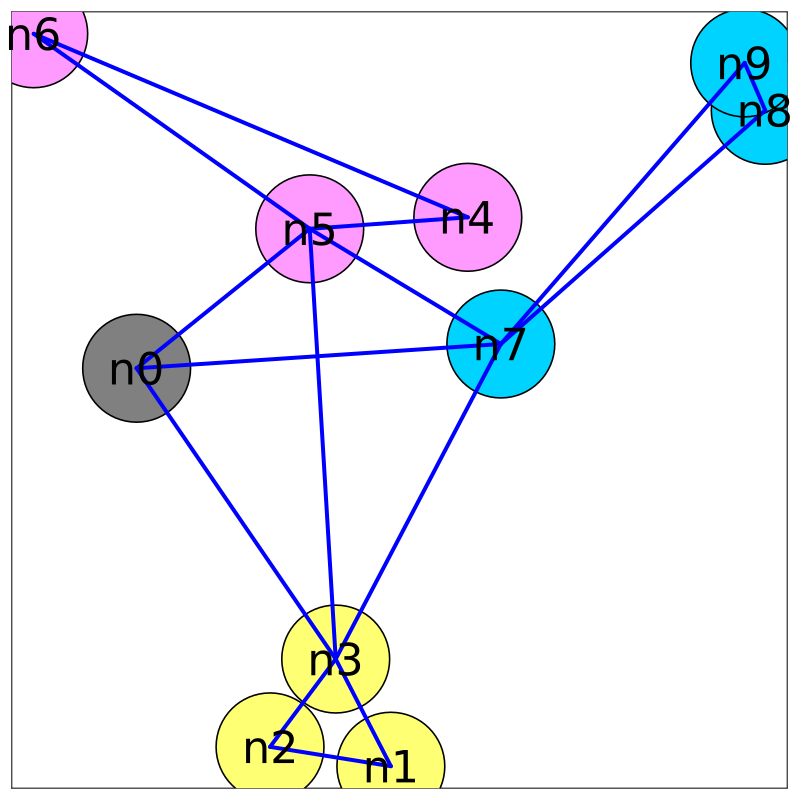

In [23]:
plt_graph = PlasmoPlots.layout_plot(graph0, node_labels=true, markersize=60, labelsize=30, linewidth=4, subgraph_colors=true, layout_options=Dict(:tol=>0.01,:C=>2,:K=>1,:iterations=>5))

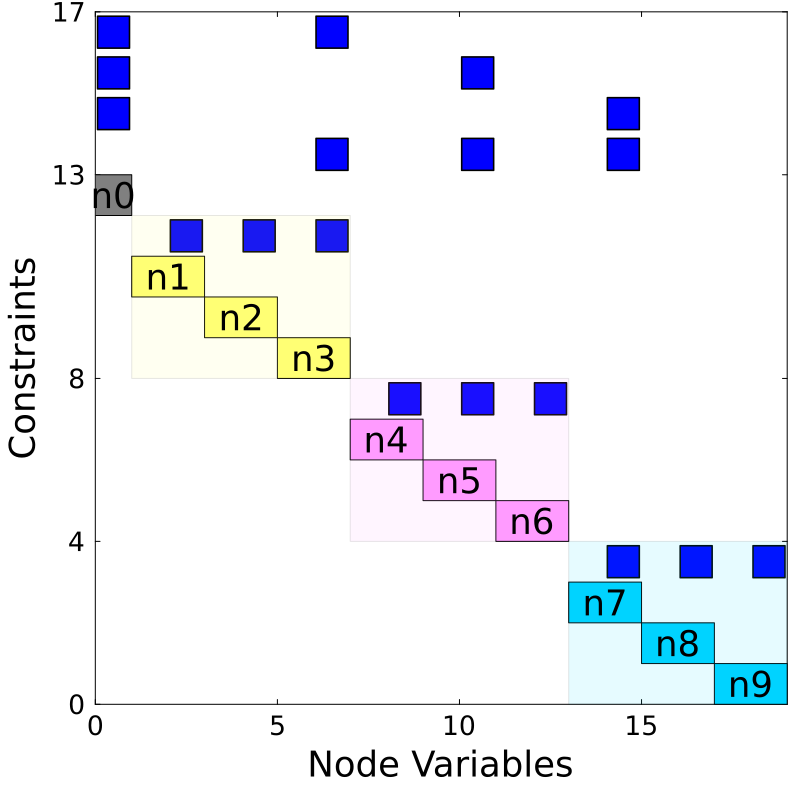

In [24]:
plt_matrix = PlasmoPlots.matrix_plot(graph0, node_labels=true, subgraph_colors=true, markersize=16)